In [247]:
'''This is just a shell, need to configure more sophisticated nn'''
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import torch.nn as nn
import torch
device = 'mps'

data = np.load('sim_data.npy')
zero_rows_mask = np.all(data == 0, axis=(1,2,3))
data = data[~zero_rows_mask]
print(data.shape)

(9647, 2, 32, 1024)


In [248]:
num_epochs = 50
batch_size = 32
learning_rate = 1e-3
num_examples = len(data)

In [249]:
X, Y = data[:, 0], data[:, 1]
print(X.shape, Y.shape)
X_train, Y_train, X_test, Y_test = X[:int(num_examples * 0.8)], Y[:int(num_examples * 0.8)], X[int(num_examples * 0.8):], Y[int(num_examples * 0.8):]

(9647, 32, 1024) (9647, 32, 1024)


In [250]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)

In [251]:
class ResNetBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, padding=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

In [252]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.stack = nn.Sequential(
            ResNetBlock(32),
            ResNetBlock(32),
            ResNetBlock(32),
            nn.Conv1d(32, 32, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.stack(x)
        return x

model = Net().to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [253]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_Y = Y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        l = loss(outputs, batch_Y)
        l.backward()
        optimizer.step()

        total_loss += l.item() 
    print(f"Epoch {epoch+1}, Loss: {total_loss / (len(X) // batch_size)}")

Epoch 1, Loss: 0.05122952337262292
Epoch 2, Loss: 0.005565949245371494
Epoch 3, Loss: 0.004022245616358133
Epoch 4, Loss: 0.0032534554308323665
Epoch 5, Loss: 0.002763850733937937
Epoch 6, Loss: 0.002437427326684131
Epoch 7, Loss: 0.002201592640570702
Epoch 8, Loss: 0.0020165857580487314
Epoch 9, Loss: 0.001860730438586015
Epoch 10, Loss: 0.0017304301770106948
Epoch 11, Loss: 0.001617618050562385
Epoch 12, Loss: 0.0015225104598538869
Epoch 13, Loss: 0.001440088253428052
Epoch 14, Loss: 0.0013694383928775046
Epoch 15, Loss: 0.0013097201866961
Epoch 16, Loss: 0.001257304062345916
Epoch 17, Loss: 0.0012127675802177716
Epoch 18, Loss: 0.001171504834626625
Epoch 19, Loss: 0.0011342179696957435
Epoch 20, Loss: 0.00110118713812358
Epoch 21, Loss: 0.0010711898173644916
Epoch 22, Loss: 0.0010443037310831768
Epoch 23, Loss: 0.001018897047037401
Epoch 24, Loss: 0.0009972281381565198
Epoch 25, Loss: 0.0009744290851885794
Epoch 26, Loss: 0.0009556459657464214
Epoch 27, Loss: 0.0009367826955154711
E

/var/folders/ky/8q3h2wmx15s9bt4sh3wjcqzm0000gn/T/ipykernel_7312/3399982262.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  example = model(torch.tensor(X_test[test_index:test_index + 1], dtype=torch.float32).to(device)).detach().cpu().numpy()


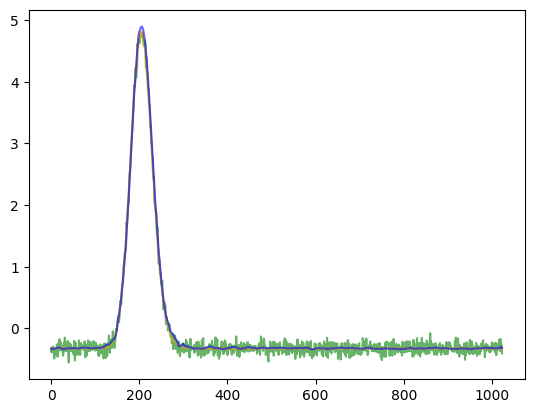

In [282]:
torch.save(model.state_dict(), 'wideband_denoise.pth')
test_index = rd.randint(0, len(X_test) - 1)

example = model(torch.tensor(X_test[test_index:test_index + 1], dtype=torch.float32).to(device)).detach().cpu().numpy()


plt.plot(X_test[test_index, 16, :].cpu(), label='Input', color='green', alpha=0.6)
plt.plot(Y_test[test_index, 16, :].cpu(), label='True', color='orange', alpha=0.6)
plt.plot(example[0, 16, :], label='Predicted', color='blue', alpha=0.6)